Custom GMM Parameters:
Weights: [0.12840467 0.65296562 0.21862971]
Means:
 [[-1.31368871  0.88502768]
 [-0.21050174 -0.59400118]
 [ 1.40024047  1.25426989]]

Sklearn GMM Parameters:
Weights: [0.12840467 0.57564122 0.29595411]
Means:
 [[-1.31368871  0.88502768]
 [ 0.70208358  0.42356609]
 [-0.79561149 -1.2078352 ]]


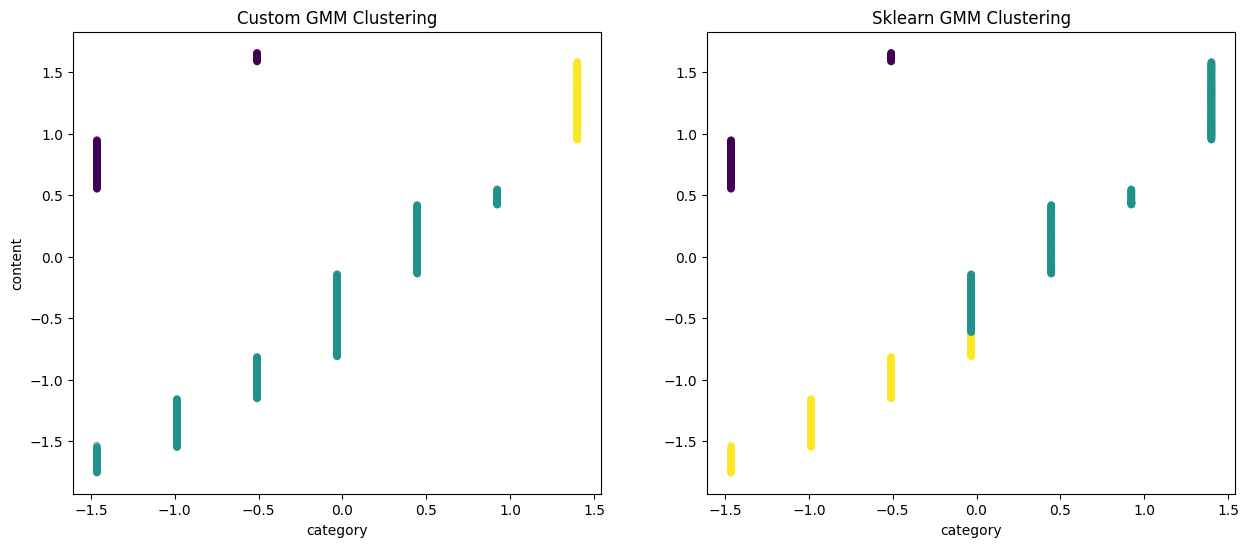

✅ Custom GMM benchmark verisi başarıyla eklendi.
✅ Sklearn GMM benchmark verisi başarıyla eklendi.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import json
import os


# 1. VERİ HAZIRLAMA
def prepare_data(filepath, n_features=2):
    """Veriyi yükleyip ölçeklendirir"""
    df = pd.read_csv(filepath)

    # Kategorik verileri sayısallaştır
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = pd.factorize(df[col])[0]

    # Sayısal sütunları seç
    numeric_df = df.select_dtypes(include=np.number).iloc[:, :n_features].dropna()
    scaler = StandardScaler()
    return scaler.fit_transform(numeric_df), numeric_df.columns

# 2. SIFIRDAN GMM IMPLEMENTASYONU
class CustomGMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        # 1. Başlangıç parametreleri
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.cov(X.T) for _ in range(self.n_components)]

        # 2. EM Algoritması
        prev_log_likelihood = 0
        for iteration in range(self.max_iter):
            # E-step: Responsibility hesaplama
            responsibilities = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                responsibilities[:, k] = self.weights_[k] * multivariate_normal.pdf(
                    X, mean=self.means_[k], cov=self.covariances_[k])
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)

            # M-step: Parametre güncelleme
            Nk = responsibilities.sum(axis=0)
            self.weights_ = Nk / n_samples
            self.means_ = (responsibilities.T @ X) / Nk[:, None]

            for k in range(self.n_components):
                diff = X - self.means_[k]
                self.covariances_[k] = (responsibilities[:, k] * diff.T) @ diff / Nk[k]
                self.covariances_[k] += 1e-6 * np.eye(n_features)  # Regularizasyon

            # Yakınsama kontrolü
            log_likelihood = self._compute_log_likelihood(X)
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

        self.n_iter_ = iteration + 1
        return self

    def _compute_log_likelihood(self, X):
        likelihood = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            likelihood[:, k] = self.weights_[k] * multivariate_normal.pdf(
                X, mean=self.means_[k], cov=self.covariances_[k])
        return np.log(likelihood.sum(axis=1)).sum()

    def predict(self, X):
        probs = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            probs[:, k] = multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])
        return np.argmax(probs, axis=1)

def save_to_benchmark(X, labels, model_name, accuracy=None):
    sil_score = silhouette_score(X, labels)
    calinski_score = calinski_harabasz_score(X, labels)
    davies_score = davies_bouldin_score(X, labels)

    benchmark_entry = {
        "vectorizer": "TF-IDF",
        "cluster_model": model_name,
        "accuracy": float(round(accuracy, 4)) if accuracy is not None else "N/A",
        "silhouette": float(round(sil_score, 4)),
        "calinski_harabasz": float(round(calinski_score, 4)),
        "davies_bouldin": float(round(davies_score, 4))
    }

    benchmark_path = "../../Outputs/benchmark.json"
    if os.path.exists(benchmark_path):
        with open(benchmark_path, "r", encoding="utf-8") as f:
            try:
                benchmark_data = json.load(f)
            except json.JSONDecodeError:
                benchmark_data = []
    else:
        benchmark_data = []

    benchmark_data.append(benchmark_entry)

    with open(benchmark_path, "w", encoding="utf-8") as f:
        json.dump(benchmark_data, f, indent=4, ensure_ascii=False)

    print(f"✅ {model_name} benchmark verisi başarıyla eklendi.")

# 3. GÖRSELLEŞTİRME
def plot_results(X, custom_labels, sklearn_labels, features):
    plt.figure(figsize=(15, 6))

    plt.subplot(121)
    plt.scatter(X[:, 0], X[:, 1], c=custom_labels, cmap='viridis', s=20, alpha=0.6)
    plt.title('Custom GMM Clustering')
    plt.xlabel(features[0])
    plt.ylabel(features[1])

    plt.subplot(122)
    plt.scatter(X[:, 0], X[:, 1], c=sklearn_labels, cmap='viridis', s=20, alpha=0.6)
    plt.title('Sklearn GMM Clustering')
    plt.xlabel(features[0])
    plt.show()

# 4. KARŞILAŞTIRMALI TEST
def main():
    # Veriyi yükle
    X, features = prepare_data('../../Datas/data.csv')

    # Custom GMM
    custom_gmm = CustomGMM(n_components=3)
    custom_gmm.fit(X)
    custom_labels = custom_gmm.predict(X)

    # Sklearn GMM
    sklearn_gmm = GaussianMixture(n_components=3)
    sklearn_labels = sklearn_gmm.fit_predict(X)

    # Sonuçları karşılaştır
    print("Custom GMM Parameters:")
    print(f"Weights: {custom_gmm.weights_}")
    print(f"Means:\n {custom_gmm.means_}")

    print("\nSklearn GMM Parameters:")
    print(f"Weights: {sklearn_gmm.weights_}")
    print(f"Means:\n {sklearn_gmm.means_}")

    # Görselleştirme
    plot_results(X, custom_labels, sklearn_labels, features)

    save_to_benchmark(X, custom_labels,  "Custom GMM")
    save_to_benchmark(X, sklearn_labels, "Sklearn GMM")

if __name__ == "__main__":
    main()